In [93]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
from scipy.special import erf
import scipy.constants as constants
from astropy.table import Table, vstack

homepath = "/global/homes/c/cpopik"
packpath = "/global/homes/c/cpopik/Packages/"  # This is where your packages should be

sys.path.append(packpath + "hmvec/")
import camb
import hmvec as hm

sys.path.append(packpath+'emu_CAMELS/ostrich/')
sys.path.append(packpath+'emu_CAMELS/')
sys.path.append(packpath+"emu_CAMELS/scripts/LH_emulator/")
import helper_functions_LH as fs

matplotlib.rcParams['figure.figsize']=[5.0, 5.0]
matplotlib.rcParams['figure.dpi']=100
matplotlib.rcParams['font.size']=14

# Initializing Emulator

In [23]:
logMs = np.linspace(11.5, 15, 200)

# Create model
zs = np.linspace(0.,3.,20)  # 20, DOES change MCMC time
# ms = np.geomspace(2e10,1e17,200)  # 200, DOES change MCMC time
ms = np.geomspace(10**12.5,10**max(logMs),200)
ks = np.geomspace(1e-4,100,1001)  # 1001, doesn't really change MCMC time
hcos = hm.HaloModel(zs,ks,ms=ms)

xmax = 20  # 20, doesn't really change MCMC time
nxs = 5000  # 5000, DOES change MCMC Time

/global/homes/c/cpopik/Packages/hmvec/hmvec/fft.py:90: RuntimeWarning: invalid value encountered in divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


In [262]:
home=packpath+'emu_CAMELS/mopc_profiles/' #point to your profiles
suite='IllustrisTNG'  # Simulation suite to emulate (SIMBA, IllustrisTNG)
prof='pth_mean'  # Profile to output (rho_mean, rho_med, pth_mean, pth_med)
func_str='linear' #this is the Rbf interpolation function

samples,x,y,emulator=fs.build_emulator_CMASS(home,suite,prof,func_str)

In [246]:
zsgrid = np.meshgrid(hcos.zs, np.log10(hcos.ms))[0]
msgrid = np.meshgrid(hcos.zs, np.log10(hcos.ms))[1]

def emu_profiles(emulator, params):
    [om,s8,asn1,agn1,asn2,agn2] = params
    omgrid = om*np.ones(zsgrid.shape)
    s8grid = s8*np.ones(zsgrid.shape)
    asn1grid = asn1*np.ones(zsgrid.shape)
    agn1grid = agn1*np.ones(zsgrid.shape)
    asn2grid = asn2*np.ones(zsgrid.shape)
    agn2grid = agn2*np.ones(zsgrid.shape)
    params = np.array((omgrid, s8grid, asn1grid, agn1grid, asn2grid, agn2grid, zsgrid, msgrid)).T.reshape(hcos.zs.size*hcos.ms.size, 8)
    profiles = 10**(emulator(params).T.reshape(hcos.zs.size, hcos.ms.size, x_y.size))
    return profiles

In [247]:
# Params are Om, s8, ASN1, AGN1, ASN2, AGN2
params = [0.3, 0.8, 1, 1, 1, 1]

unitconversion = (14/27)*(3.086e24/1.989e33)  # go from cgs to solar masses and Mpc, and P_th to P_e
Pths_emu = unitconversion*emu_profiles(emulator, params)   # Dimensions should be (zdim, mdim, xdim)
# At this point we should have what is called presFunc

In [259]:
samples

array([[ 0.309  ,  0.979  ,  3.11234, ...,  0.53182,  0.     , 11.25   ],
       [ 0.309  ,  0.979  ,  3.11234, ...,  0.53182,  0.     , 11.75   ],
       [ 0.309  ,  0.979  ,  3.11234, ...,  0.53182,  0.04852, 11.25   ],
       ...,
       [ 0.4322 ,  0.6142 ,  1.28521, ...,  0.86754,  0.46525, 11.75   ],
       [ 0.4322 ,  0.6142 ,  1.28521, ...,  0.86754,  0.53726, 11.25   ],
       [ 0.4322 ,  0.6142 ,  1.28521, ...,  0.86754,  0.53726, 11.75   ]])

# Get into hmvec

In [101]:
def Nc_LRG(logM, params):
    f_ic, logM_cut, sigma = [params.get(key) for key in ['f_ic', 'logM_cut', 'sigma']]
    return (f_ic / 2) * (1- erf((logM_cut - logM)/(np.sqrt(2)*sigma)))

def Ns_LRG(logM, Nc, params):
    kappa, logM_cut, logM_1, alpha = [params.get(key) for key in ['kappa', 'logM_cut', 'logM_1', 'alpha']]
    M, M_cut, M_1 = 10**logM, 10**logM_cut, 10**logM_1
    return ((M - kappa * M_cut) / M_1)**alpha * Nc

LRG_paper_params = {
    'logM_cut': np.array([12.7]*len(logMs)),
    'logM_1': np.array([13.6]*len(logMs)),
    'sigma': 0.2,
    'alpha': 1.15,
    'kappa': 0.08,
    'f_ic': 0.8
}


mthresh=10**10.5+zs*0.
hcos.add_custom_hod(name="LRG_HOD",mthresh=mthresh, ignore_existing=True, 
                    Nc_model=Nc_LRG, Ns_model=Ns_LRG, 
                    model_params=LRG_paper_params, z_dep=False)

hcos.add_battaglia_pres_profile("y",family='pres', xmax=xmax,nxs=nxs, ignore_existing=True)

/global/homes/c/cpopik/Packages/hmvec/hmvec/fft.py:90: RuntimeWarning: invalid value encountered in divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


In [163]:
Pths_emu.shape

(20, 200, 16)

In [174]:
def Functest0(xs0, z, m):
    return Pths_emu[z, m, list(xs[z, m]).index(xs0)]

FuncTest = lambda xs0: Functest0(xs0, hcos.zs, hcos.ms)

In [175]:
FuncTest(2)

IndexError: arrays used as indices must be of integer (or boolean) type

In [180]:
def fft_integral(x,y,axis=-1):
    """
    Calculates
    \int dx x sin(kx) y(|x|) from 0 to infinity using an FFT,
    which appears often in fourier transforms of 1-d profiles.
    For y(x) = exp(-x**2/2), this has the analytic solution
    sqrt(pi/2) exp(-k**2/2) k
    which this function can be checked against.
    """
    assert x.ndim==1
    extent = x[-1]-x[0]
    N = x.size
    step = extent/N
    integrand = x*y
    uk = -np.fft.rfft(integrand,axis=axis).imag*step
    ks = np.fft.rfftfreq(N, step) *2*np.pi
    return ks,uk

In [245]:
rhos=Pths_emu
ks=hcos.ks
zs=hcos.zs
rss = r200critz  #  Dimensions of (zdim, mdim, 1)
xs = x[None, None, :]*np.ones((hcos.zs.size, hcos.ms.size, x.size))/rss[..., None]  # dimensions should be (xdim)
rvir = hcos.rvir(hcos.ms[None,:],hcos.zs[:,None])
cmaxs = rvir/rss  # Dimension should be (zim, mdim)
do_mass_norm=False
rss = r200critz[..., None]



if rhos.ndim==1:
    rhos = rhos[None,None]
else:
    assert rhos.ndim==3
rhos = rhos + cmaxs[...,None]*0.
theta = np.ones(rhos.shape)
theta[np.abs(xs)>cmaxs[...,None]] = 0 # CHECK
# m
integrand = theta * rhos * xs**2.
mnorm = np.trapz(integrand,xs) # mass but off by norm same as rho is off by
if not(do_mass_norm):
    mnorm *= 0
    mnorm +=1
# u(kt)
integrand = rhos*theta
kts,ukts = fft_integral(xs,integrand)
uk = ukts/kts[None,None,:]/mnorm[...,None]
kouts = kts/rss/(1+zs[:,None,None]) # divide k by (1+z) here for comoving FIXME: check this!
ukouts = np.zeros((uk.shape[0],uk.shape[1],ks.size))
# sadly at this point we must loop to interpolate :(
# from orphics import io
# pl = io.Plotter(xyscale='loglog')
for i in range(uk.shape[0]):
    for j in range(uk.shape[1]):
        pks = kouts[i,j]
        puks = uk[i,j]
        puks = puks[pks>0]
        pks = pks[pks>0]
        ukouts[i,j] = np.interp(ks,pks,puks,left=puks[0],right=0)
        #TODO: Add compulsory debug plot here
#         pl.add(ks,ukouts[i,j])
# pl.hline(y=1)
# pl.done()

AssertionError: 

In [240]:
radii = x[None, None, :]*np.ones((hcos.zs.size, hcos.ms.size, x.size))

In [244]:
radii[6, 10]

array([6.70602911e-04, 1.16537429e-03, 2.02518841e-03, 3.51937411e-03,
       6.11597124e-03, 1.06283399e-02, 1.84699379e-02, 3.20970733e-02,
       5.57783206e-02, 9.69316118e-02, 1.68447835e-01, 2.92728788e-01,
       5.08704330e-01, 8.84026806e-01, 1.53626252e+00, 2.66971827e+00])

In [149]:
rss = r200critz  #  Dimensions of (zdim, mdim, 1)
xs = x[None, None, :]*np.ones((hcos.zs.size, hcos.ms.size, x.size))/rss[..., None]  # dimensions should be (xdim)

rvir = hcos.rvir(hcos.ms[None,:],hcos.zs[:,None])
cmaxs = rvir/rss  # Dimension should be (zim, mdim)
# cmaxs = hcos.rvir(hcos.ms[None, :], hcos.zs[:, None])

profileemuhm_y = hm.fft.generic_profile_fft_new(Pths_emu, xs, cmaxs, rss[..., None], hcos.zs, hcos.ks, do_mass_norm=False)[1]

# At this points we should have what is called pkouts

AssertionError: 

In [112]:
Pths_emu.shape

(20, 200, 16)

In [103]:
rhocritz = hcos.rho_critical_z(hcos.zs)
if hcos.mdef=='vir':
    delta_rhos1 = rhocritz*hcos.deltav(hcos.zs)
elif hcos.mdef=='mean':
    delta_rhos1 = hcos.rho_matter_z(hcos.zs)*200.
cs = hcos.concentration()
delta_rhos2 = 200.*hcos.rho_critical_z(hcos.zs)

sigmaT=constants.physical_constants['Thomson cross section'][0] # units m^2
mElect=constants.physical_constants['electron mass'][0] / (1.989e30)# units kg
m200critz = hm.mdelta_from_mdelta(hcos.ms,cs,delta_rhos1,delta_rhos2)
r200critz = hm.R_from_M(m200critz,hcos.rho_critical_z(hcos.zs)[:,None],delta=200.)

unitconversion2 = 4*np.pi*(sigmaT/(mElect*constants.c**2))* \
                (r200critz**3*((1+hcos.zs)**2/hcos.h_of_z(hcos.zs))[...,None])[...,None] 

hcos.add_custom_pressure_profile(unitconversion2*profileemuhm_y, 'pth_emu')

# Compare to hmvec

In [192]:
family='pres'

if family is None: family = hcos.p['battaglia_pres_family'] # AGN or SH?
pparams = {}
pparams['battaglia_pres_gamma'] = hcos.p['battaglia_pres_gamma']
pparams['battaglia_pres_alpha'] = hcos.p['battaglia_pres_alpha']
pparams.update(hm.battaglia_defaults[family])


# Convert masses to m200critz
rhocritz = hcos.rho_critical_z(hcos.zs)
if hcos.mdef=='vir':
    delta_rhos1 = rhocritz*hcos.deltav(hcos.zs)
elif hcos.mdef=='mean':
    delta_rhos1 = hcos.rho_matter_z(hcos.zs)*200.
rvirs = hcos.rvir(hcos.ms[None,:],hcos.zs[:,None])
cs = hcos.concentration()
delta_rhos2 = 200.*hcos.rho_critical_z(hcos.zs)
m200critz = hm.mdelta_from_mdelta(hcos.ms,cs,delta_rhos1,delta_rhos2)
r200critz = hm.R_from_M(m200critz,hcos.rho_critical_z(hcos.zs)[:,None],delta=200.)

# Generate profiles
"""
The physical profile is rho(r) = f(2r/R200)
We rescale this to f(x), so x = r/(R200/2) = r/rgs
So rgs = R200/2 is the equivalent of rss in the NFW profile
"""
omb = hcos.p['ombh2'] / hcos.h**2.
omm = hcos.om0
presFunc = lambda x: hm.P_e_generic_x(x,m200critz[...,None],r200critz[...,None],hcos.zs[:,None,None],omb,omm,rhocritz[...,None,None],
                            alpha=pparams['battaglia_pres_alpha'],
                            gamma=pparams['battaglia_pres_gamma'],
                            P0_A0=pparams['P0_A0'],
                            P0_alpham=pparams['P0_alpham'],
                            P0_alphaz=pparams['P0_alphaz'],
                            xc_A0=pparams['xc_A0'],
                            xc_alpham=pparams['xc_alpham'],
                            xc_alphaz=pparams['xc_alphaz'],
                            beta_A0=pparams['beta_A0'],
                            beta_alpham=pparams['beta_alpham'],
                            beta_alphaz=pparams['beta_alphaz'])

rgs = r200critz
cgs = rvirs/rgs
sigmaT=constants.physical_constants['Thomson cross section'][0] # units m^2
mElect=constants.physical_constants['electron mass'][0] / hm.default_params['mSun']# units kg
ks,pkouts = hm.generic_profile_fft(presFunc,cgs,rgs[...,None],hcos.zs,hcos.ks,xmax,nxs,do_mass_norm=False)
pk_profile = pkouts.copy()*4*np.pi*(sigmaT/(mElect*constants.c**2))*(r200critz**3*((1+hcos.zs)**2/hcos.h_of_z(hcos.zs))[...,None])[...,None]   

In [218]:
rhofunc_x = presFunc
cmaxs = cgs
rss = rgs[...,None]
zs = hcos.zs
ks = hcos.ks
xmax = xmax
nxs = nxs
do_mass_norm=False

xs = np.linspace(0.,xmax,nxs+1)[1:]
rhos = rhofunc_x(xs)
if rhos.ndim==1:
    rhos = rhos[None,None]
else:
    assert rhos.ndim==3
rhos = rhos + cmaxs[...,None]*0.
theta = np.ones(rhos.shape)
theta[np.abs(xs)>cmaxs[...,None]] = 0 # CHECK
# m
integrand = theta * rhos * xs**2.
mnorm = np.trapz(integrand,xs) # mass but off by norm same as rho is off by
if not(do_mass_norm):
    mnorm *= 0
    mnorm +=1
# u(kt)
integrand = rhos*theta
kts,ukts = fft_integral(xs,integrand)
uk = ukts/kts[None,None,:]/mnorm[...,None]
kouts = kts/rss/(1+zs[:,None,None]) # divide k by (1+z) here for comoving FIXME: check this!
ukouts = np.zeros((uk.shape[0],uk.shape[1],ks.size))
# sadly at this point we must loop to interpolate :(
# from orphics import io
# pl = io.Plotter(xyscale='loglog')
for i in range(uk.shape[0]):
    for j in range(uk.shape[1]):
        pks = kouts[i,j]
        puks = uk[i,j]
        puks = puks[pks>0]
        pks = pks[pks>0]
        ukouts[i,j] = np.interp(ks,pks,puks,left=puks[0],right=0)
        #TODO: Add compulsory debug plot here
#         pl.add(ks,ukouts[i,j])
# pl.hline(y=1)
# pl.done()

/tmp/ipykernel_160095/2263548717.py:28: RuntimeWarning: invalid value encountered in divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


In [221]:
pks.shape

(2500,)

12.574890831628633 0.00687932809534911


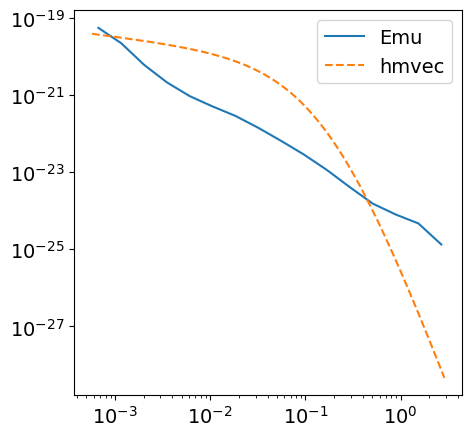

In [105]:
# print(Pths_emu[:, :, 0]/presFunc(xs)[:, :, 0])
print(max(np.ravel(Pths_emu[:, :, 0]/presFunc(xs)[:, :, 0])), 
      min(np.ravel(Pths_emu[:, :, 0]/presFunc(xs)[:, :, 0])))

xs = np.linspace(0.,xmax,nxs+1)[1:]
xreal = xs[None, None, :]*rgs[:, :, None]


i, j=15, 10

plt.plot(x, Pths_emu[i,j], label='Emu')
plt.plot(xreal[i,j], presFunc(xs)[i, j], label='hmvec', ls='--')
plt.xscale('log'), plt.yscale('log')
plt.legend()
plt.show()

0.22168765421569092 0.0


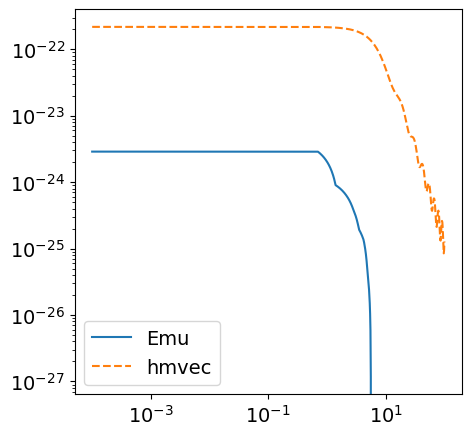

In [106]:
print(max(np.ravel(profileemuhm_y/pkouts)), 
      min(np.ravel(profileemuhm_y/pkouts)))

plt.plot(hcos.ks, profileemuhm_y[i, j], label='Emu')
plt.plot(hcos.ks, pkouts[i, j], label='hmvec', ls='--')
plt.xscale('log'), plt.yscale('log')
plt.legend()
plt.show()

0.22168765421569087 0.0


[]

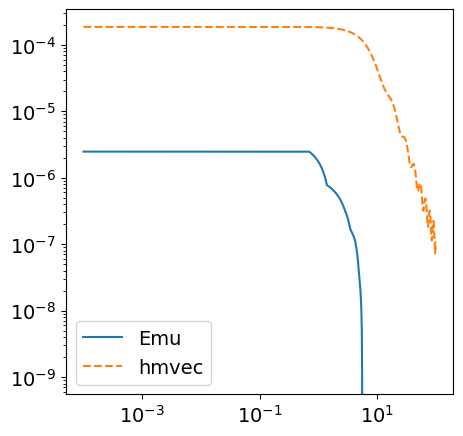

In [107]:
print(max(np.ravel(hcos.pk_profiles['pth_emu']/hcos.pk_profiles['y'])), 
      min(np.ravel(hcos.pk_profiles['pth_emu']/hcos.pk_profiles['y'])))

plt.plot(hcos.ks, hcos.pk_profiles['pth_emu'][i,j], label='Emu')
plt.plot(hcos.ks, hcos.pk_profiles['y'][i, j], label='hmvec', ls='--')
plt.xscale('log'), plt.yscale('log')
plt.legend()
plt.plot()

# Get final Cls

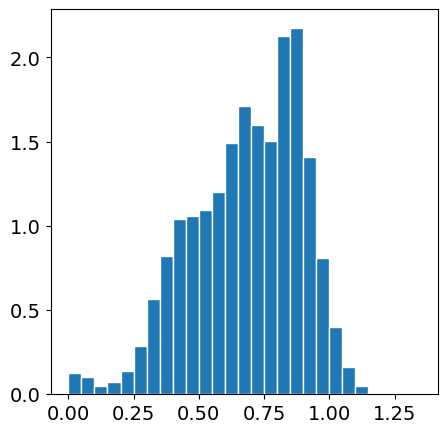

In [94]:
table = Table.read(homepath + '/Results/DESI_LRGs_ACTD56.csv')
targetdata = table.to_pandas()

# Sets RA limits to match ACT maps
targetdata['RA'].where(targetdata['RA'] < 180, targetdata['RA'] - 360, inplace=True)

data_zs = targetdata['Z_PHOT_MEAN'].values
area = (max(targetdata.RA)-min(targetdata.RA))*(max(targetdata.DEC)-min(targetdata.DEC))

gdndz, gzs = plt.hist(data_zs, bins=np.arange(0, 1.4, 0.05), ec='w', weights=np.ones(len(data_zs))/area, density=True)[0:2]

In [95]:
Pgy = hcos.get_power('LRG_HOD', 'y', verbose=False);
Pgg = hcos.get_power('LRG_HOD', verbose=False);
Pyy = hcos.get_power('y', verbose=False);


ls = np.linspace(0, 6000, 6001)

C_gy = hcos.C_gy_new(ls, zs, ks, Pgy, gzs=gzs[1:], gdndz=gdndz)
C_gg = hcos.C_gg_new(ls, zs, ks, Pgg, gzs=gzs[1:], gdndz=gdndz)
C_yy = hcos.C_yy_new(ls, zs, ks, Pyy, gzs=gzs[1:])

Check the consistency relation for tSZ
Check the consistency relation for tSZ
Check the consistency relation for tSZ


In [96]:
Pggemu = hcos.get_power('LRG_HOD', verbose=False)

Pygemu = hcos.get_power('pth_emu', 'LRG_HOD', verbose=False)

Pyyemu = hcos.get_power('pth_emu', verbose=False)

C_gg_emu = hcos.C_gg_new(ls, hcos.zs, hcos.ks, Pggemu, gzs=gzs[1:], gdndz=gdndz)
C_yg_emu = hcos.C_gy_new(ls, hcos.zs, hcos.ks, Pygemu, gzs=gzs[1:], gdndz=gdndz)
C_yy_emu = hcos.C_gy_new(ls, hcos.zs, hcos.ks, Pyyemu, gzs=gzs[1:], gdndz=gdndz)

Check the consistency relation for tSZ
Check the consistency relation for tSZ
Check the consistency relation for tSZ


In [97]:
resultspath="/global/homes/c/cpopik/Results/"
ls_data = np.load(resultspath+"ls_NW.npy")
Cl_gy_data = np.load(resultspath+"LRGs_y_Cls_NW.npy")
Cl_gg_data = np.load(resultspath+"LRGs_LRGs_Cls_NW.npy")
Cl_yy_data = np.load(resultspath+"y_y_Cls_NW.npy")

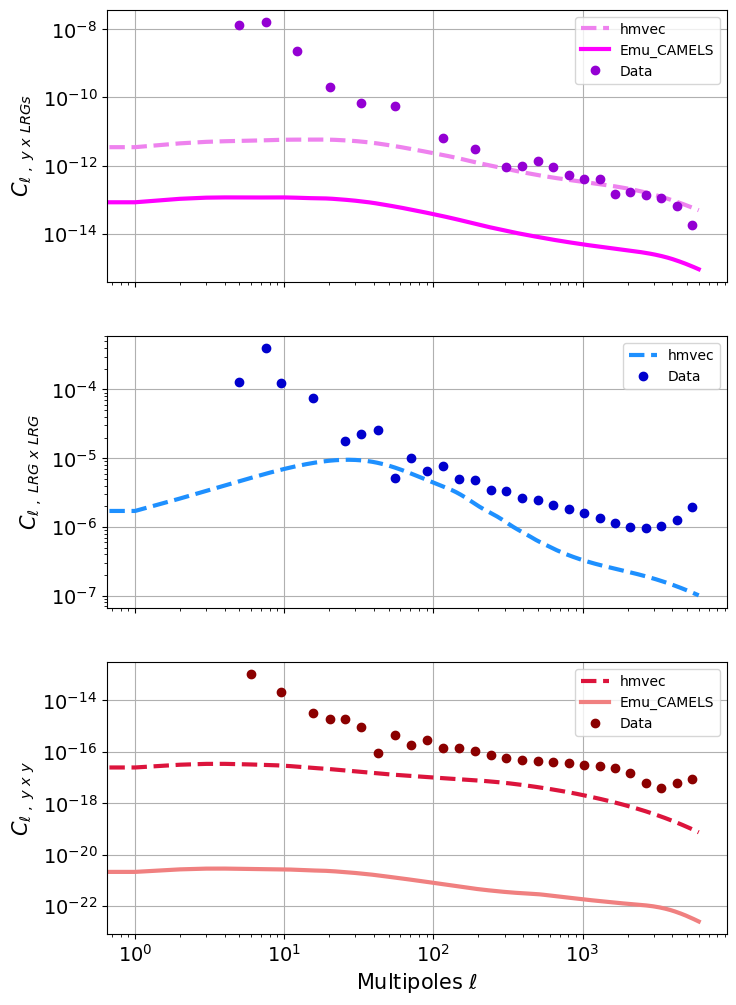

In [98]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 12))

ax3.set_xlabel('Multipoles $\\ell$', fontsize=15), ax3.set_xscale('log')


ax1.plot(ls, C_gy, c='violet', lw=3, ls='--', label='hmvec')
ax1.plot(ls, C_yg_emu, lw=3, c='magenta', label='Emu_CAMELS')
ax1.plot(ls_data, Cl_gy_data, marker='o', lw=0, c='darkviolet', label='Data')

ax1.set_ylabel('$C_{\\ell \ , \ y \ x \  LRGs}$', fontsize=15), ax1.set_yscale('log')
ax1.grid(True), ax1.legend(fontsize=10)


ax2.plot(ls, C_gg, c='dodgerblue', lw=3, ls='--', label='hmvec')
ax2.plot(ls_data, Cl_gg_data, marker='o', lw=0, c='mediumblue', label='Data')

ax2.set_ylabel('$C_{\\ell \ , \ LRG \ x \ LRG}$', fontsize=15),  ax2.set_yscale('log')
ax2.grid(True), ax2.legend(fontsize=10)


ax3.plot(ls, C_yy, c='crimson', lw=3, ls='--', label='hmvec')
ax3.plot(ls, C_yy_emu, lw=3, c='lightcoral', label='Emu_CAMELS')
ax3.plot(ls_data, Cl_yy_data, marker='o', lw=0, c='darkred', label='Data')

ax3.set_ylabel('$C_{\\ell \ , \ y \ x \ y}$', fontsize=15),  ax3.set_yscale('log')
ax3.grid(True), ax3.legend(fontsize=10)


plt.show()